## Model Training (Done on Google Collab)
### VGG19 train & tune
### DenseNet train & tune
### Xception train & tune

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Package & Dependencies Setup

In [ ]:
"""Install NSL package"""
!pip install --upgrade neural_structured_learning
!pip install tensorflow-addons

     |████████████████████████████████| 122kB 11.1MB/s 
     |████████████████████████████████| 706kB 12.2MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_structured_learning.tools import graph_utils
import neural_structured_learning as nsl
import tensorflow_addons as tfa
from copy import deepcopy
from sklearn.metrics import multilabel_confusion_matrix
import random
import os
import PIL
import time
import re

tf.keras.backend.clear_session()
print("tensorflow version: ", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices('GPU') else "NOT AVAILABLE")

tensorflow version:  2.4.1
keras version 2.4.0
Eager mode:  True
GPU is available


In [ ]:
from graph_data_processing import GraphDataProcess
from AAE_model import AAE
from Kmeans import KMeans, KMeansModels
from nsl_data_processing import GenerateTrainTestDict, NSLDataFormat
from AD_model_builder import AD_params, ADModelBuilder, AccEarlyStop

In [ ]:
''' label definition: NonDemented - 0, VeryMildDemented - 1, MildDemented -2, ModerateDemented -3 '''
label_list = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
root_path = '/content/drive/MyDrive/AD Expriment II/graph_images/'
train_root_path = f'{root_path}train/'
test_root_path = f'{root_path}test/'

train_path_list = [f'{train_root_path}{label}/' for label in label_list]
train_tfr_list = [f'{train_root_path}{label}.tfr' for label in label_list]

test_path_list = [f'{test_root_path}{label}/' for label in label_list]
test_tfr_list = [f'{test_root_path}{label}.tfr' for label in label_list]

tfr_rep_list = [f'{train_root_path}{label}_AAErep.tfr' for label in label_list]

train_tfr_path = f'{train_root_path}train_data.tfr'

#2.VGG19 & VGG19-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 2.1 VGG19 Base Model Training
### val_acc: 0.64, val_auc: 0.89, val_f1_score: 0.64

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base'
params.early_stop_base_line=0.90
params.train_epoch=50
"""build a base_model and restore weights from last training"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',  tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                147488    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________

In [ ]:
'''train base model'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, 
                                                          mode='max',save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpoints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


    160/Unknown - 28s 159ms/step - loss: 1.0112 - accuracy: 0.5801 - auc: 0.8262 - f1_score: 0.4933

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


160/160 [==============================] - 31s 182ms/step - loss: 1.0101 - accuracy: 0.5805 - auc: 0.8265 - f1_score: 0.4937 - val_loss: 1.4173 - val_accuracy: 0.3753 - val_auc: 0.6352 - val_f1_score: 0.2414

Epoch 00001: val_accuracy improved from -inf to 0.37529, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base
Epoch 2/50
160/160 [==============================] - 30s 181ms/step - loss: 0.6073 - accuracy: 0.7445 - auc: 0.9359 - f1_score: 0.6846 - val_loss: 1.1158 - val_accuracy: 0.5465 - val_auc: 0.8065 - val_f1_score: 0.4966

Epoch 00002: val_accuracy improved from 0.37529 to 0.54652, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base
Epoch 3/50
160/160 [==============================] - 30s 179ms/step - loss: 0.5309 - accuracy: 0.7771 - auc: 0.9508 - f1_score: 0.7323 - val_loss: 1.4043 - val_accuracy: 0.4934 - val_auc: 0.7588 - val_f1_score: 0.4842

Epoch 00003: val_accuracy did not impr

In [ ]:
'''evaluate the base model'''
base_model.evaluate(test_image_dataset)

1/1 [==============================] - 3s 3s/step - loss: 1.4312 - accuracy: 0.6403 - auc: 0.8503 - f1_score: 0.6390


[1.4311827421188354,
 0.6403440237045288,
 0.8503028750419617,
 0.6390205025672913]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

In [ ]:
len(data)

1279

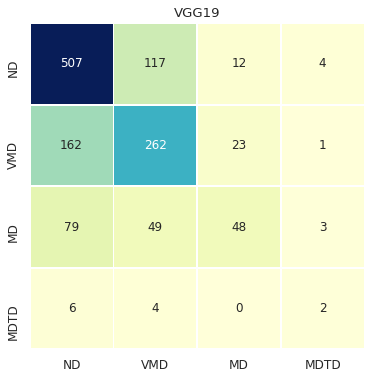

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "VGG19")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model,data, data_label)

TN: [2809 2680 2795 2863]
TP: [838 859 876 918]
FN: [153  79  58  47]
FP: [ 28 210  99   0]
Acc: [0.95271682 0.92450366 0.95898642 0.98772205]
ER(Error rate): [0.04728318 0.07549634 0.04101358 0.01227795]
Recall(TP rate): [0.84561049 0.91577825 0.9379015  0.95129534]
Specialty(TN rate): [0.99013042 0.92733564 0.96579129 1.        ]
Fall Out(FP rate): [0.00986958 0.07266436 0.03420871 0.        ]
Miss Rate(FN rate): [0.15438951 0.08422175 0.0620985  0.04870466]


## 2.2 VGG19-NSL Model Training
### val_acc: ???, val_auc: ???, val_f1_score: ???

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path ='/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl'
params.early_stop_base_line=0.70
params.train_epoch=100
params.nsl_multiplier = 0.8
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
"""build a base_model"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
"""build a NSL model on top of the base model and retore weights from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                147488    
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________

In [29]:
''' setup early stoping and checkpoints '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

'''NSL model training'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 162s 863ms/step - loss: 1.1171 - accuracy: 0.5694 - auc: 0.8186 - f1_score: 0.5377 - scaled_graph_loss: 0.0771 - val_loss: 1.1478 - val_accuracy: 0.5246 - val_auc: 0.7817 - val_f1_score: 0.5987

Epoch 00001: val_accuracy improved from -inf to 0.52463, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl
Epoch 2/100
160/160 [==============================] - 126s 781ms/step - loss: 0.6543 - accuracy: 0.7461 - auc: 0.9366 - f1_score: 0.7221 - scaled_graph_loss: 0.0486 - val_loss: 1.1522 - val_accuracy: 0.5285 - val_auc: 0.8211 - val_f1_score: 0.5217

Epoch 00002: val_accuracy improved from 0.52463 to 0.52854, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl
Epoch 3/100
160/160 [==============================] - 126s 782ms/step - loss: 0.5596 - accuracy: 0.7798 - auc: 0.9535 - f1_score: 0.7666 - scaled_graph_loss: 0.0418 - val_loss: 1.0028 - val_accuracy: 

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 4s 136ms/step - loss: 0.0949 - accuracy: 0.9713 - auc: 0.9969 - f1_score: 0.9710


[0.09488795697689056,
 0.9712643623352051,
 0.9968827962875366,
 0.9709879755973816]

## 3.3 VGG19-NSL 5th block tunning
### val_acc: 0.98, val_auc: 0.99, val_f1_score: 0.98

In [ ]:
'''define params'''
params.learning_rate = 0.00005
params.checkpoint_restore_path = '/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_97'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98'
params.early_stop_base_line=0.98
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base model'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').setup_VGG19_by_layer_names(trainable_layers=['block5_conv1', 
                                                                                                                                           'block5_conv2', 
                                                                                                                                           'block5_conv3', 
                                                                                                                                           'block5_conv4']).get_ADModel()
"""restore NSL model from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type, 
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.checkpoint_restore_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
trainable layer:  block5_conv1
trainable layer:  block5_conv2
trainable layer:  block5_conv3
trainable layer:  block5_conv4
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________

In [ ]:
"""set up training checkpoint and earlystop callbacks"""
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch')
callback_earlystop = AccEarlyStop(val_acc_base = params.early_stop_base_line)
"""NSL model training"""
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs= params.train_epoch,
                                        verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     69/Unknown - 52s 753ms/step - loss: 1.6121 - accuracy: 0.6404 - auc: 0.8563 - f1_score: 0.6394 - scaled_graph_loss: 0.0153
Epoch 00001: val_accuracy improved from -inf to 0.49556, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98
69/69 [==============================] - 61s 881ms/step - loss: 1.6121 - accuracy: 0.6404 - auc: 0.8563 - f1_score: 0.6394 - scaled_graph_loss: 0.0153 - val_loss: 3.0820 - val_accuracy: 0.4956 - val_auc: 0.7293 - val_f1_score: 0.5949
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.7492 - auc: 0.9392 - f1_score: 0.7464 - scaled_graph_loss: 0.0110
Epoch 00002: val_accuracy improved from 0.49556 to 0.61311, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98
69/69 [==============================] - 57s 831ms/step - loss: 0.6040 - accuracy: 0.7492 - auc: 0.9392 - f1_score: 0.7464 - scaled_graph

In [ ]:
"""evaluate tuned model"""
graph_reg_model.evaluate(test_image_dataset)

30/30 [==============================] - 4s 128ms/step - loss: 0.0699 - accuracy: 0.9822 - auc: 0.9973 - f1_score: 0.9822


[0.06989272683858871,
 0.9822361469268799,
 0.9973025321960449,
 0.9822361469268799]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


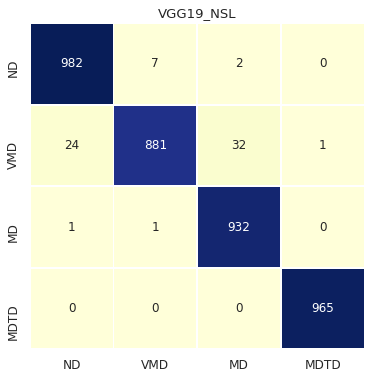

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, "VGG19_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(graph_reg_model, data, data_label)

TN: [2812 2882 2860 2862]
TP: [982 881 932 965]
FN: [ 9 57  2  0]
FP: [25  8 34  1]
Acc: [1897.  1881.5 1896.  1913.5]
ER(Error rate): [17.  32.5 18.   0.5]
Recall(TP rate): [0.99091826 0.93923241 0.99785867 1.        ]
Specialty(TN rate): [0.99118787 0.99723183 0.98825155 0.99965072]
Fall Out(FP rate): [0.00881213 0.00276817 0.01174845 0.00034928]
Miss Rate(FN rate): [0.00908174 0.06076759 0.00214133 0.        ]


# 7.DenseNet121 & DenseNet121-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 4.1 DenseNet Base Model Training
### val_acc: 0.9152, val_auc: 0.9906, val_f1_score: 0.91498

In [ ]:
'''define params'''
params.learning_rate=0.01
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91'
params.early_stop_base_line=0.91
params.train_epoch=100

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_restore_path)

'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
29089792/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)  

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     69/Unknown - 14s 206ms/step - loss: 0.9499 - accuracy: 0.5922 - auc: 0.8462 - f1_score: 0.5560

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.64159, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91
69/69 [==============================] - 21s 301ms/step - loss: 0.9499 - accuracy: 0.5922 - auc: 0.8462 - f1_score: 0.5560 - val_loss: 0.7989 - val_accuracy: 0.6416 - val_auc: 0.8905 - val_f1_score: 0.6358
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.6709 - auc: 0.9026 - f1_score: 0.6436
Epoch 00002: val_accuracy improved from 0.64159 to 0.65648, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91
69/69 [==============================] - 18s 261ms/step - loss: 0.7284 - accuracy: 0.6709 - auc: 0.9026 - f1_score: 0.6436 - val_loss: 0.7371 - val_accuracy: 0.6565 - val_auc: 0.9020 - val_f1_score: 0.6389
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.7104 - auc: 0.9244 - f1_scor

In [ ]:
'''evaluate base model'''
base_model.evaluate(test_image_dataset)

30/30 [==============================] - 2s 73ms/step - loss: 0.2432 - accuracy: 0.9127 - auc: 0.9902 - f1_score: 0.9142


[0.24320916831493378,
 0.9127481579780579,
 0.9901851415634155,
 0.9142027497291565]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

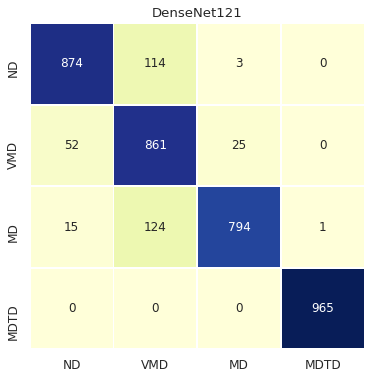

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "DenseNet121")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model, data, data_label)

TN: [2770 2652 2866 2862]
TP: [874 861 794 965]
FN: [117  77 140   0]
FP: [ 67 238  28   1]
Acc: [0.95193312 0.9177116  0.95611285 0.99973877]
ER(Error rate): [0.04806688 0.0822884  0.04388715 0.00026123]
Recall(TP rate): [0.88193744 0.91791045 0.85010707 1.        ]
Specialty(TN rate): [0.9763835  0.91764706 0.99032481 0.99965072]
Fall Out(FP rate): [0.0236165  0.08235294 0.00967519 0.00034928]
Miss Rate(FN rate): [0.11806256 0.08208955 0.14989293 0.        ]


## 4.2 DenseNet_NSL Model Training
### val_acc: 0.9227, val_auc: 0.9914, val_f1_score: 0.92



In [ ]:
'''define params'''
params.learning_rate=0.001
params.restore_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.early_stop_base_line=0.92
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     69/Unknown - 30s 430ms/step - loss: 0.9785 - accuracy: 0.6027 - auc: 0.8538 - f1_score: 0.5904 - scaled_graph_loss: 0.0198
Epoch 00001: val_accuracy improved from -inf to 0.69462, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92
69/69 [==============================] - 46s 664ms/step - loss: 0.9785 - accuracy: 0.6027 - auc: 0.8538 - f1_score: 0.5904 - scaled_graph_loss: 0.0198 - val_loss: 0.6903 - val_accuracy: 0.6946 - val_auc: 0.9165 - val_f1_score: 0.6186
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.6914 - auc: 0.9103 - f1_score: 0.6771 - scaled_graph_loss: 0.0154
Epoch 00002: val_accuracy improved from 0.69462 to 0.72518, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92
69/69 [==============================] - 34s 487ms/step - loss: 0.7261 - accuracy: 0.6914 - auc: 0.9103 - f1_score: 0.6771 - 

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

1/1 [==============================] - 0s 17ms/step - loss: 0.2339 - accuracy: 0.9222 - auc: 0.9919 - f1_score: 0.9214


[0.23390400409698486,
 0.922152578830719,
 0.9918628334999084,
 0.9213719964027405]

## 4.3 DenseNet_NSL top 20 layers and bottom 50 laysers tuning
### val_acc: 0.963, val_auc: 0.991, val_f1_score: 0.963

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
params.learning_rate=0.0001
params.restore_path= '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95'
params.early_stop_base_line=0.95
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=10, middle_layers=None, bottom_layers=50).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 106, 106, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


    137/Unknown - 94s 688ms/step - loss: 0.9150 - accuracy: 0.6490 - auc: 0.8835 - f1_score: 0.6304 - scaled_graph_loss: 0.0116
Epoch 00001: val_accuracy improved from -inf to 0.67450, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95
137/137 [==============================] - 103s 749ms/step - loss: 0.9150 - accuracy: 0.6490 - auc: 0.8835 - f1_score: 0.6304 - scaled_graph_loss: 0.0116 - val_loss: 0.6845 - val_accuracy: 0.6745 - val_auc: 0.9137 - val_f1_score: 0.6421
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7501 - auc: 0.9447 - f1_score: 0.7405 - scaled_graph_loss: 0.0074
Epoch 00002: val_accuracy improved from 0.67450 to 0.75235, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95
137/137 [==============================] - 99s 719ms/step - loss: 0.5472 - accuracy: 0.7501 - auc: 0.9447 

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 3s 44ms/step - loss: 0.1276 - accuracy: 0.9634 - auc: 0.9939 - f1_score: 0.9635


[0.1275724619626999,
 0.9634273648262024,
 0.9939191937446594,
 0.9634959697723389]

## 4.4 DenseNet_NSL top 20 layers, middle 30 layers and bottom 20 laysers tuning
### val_acc: 0.9864, val_auc: 0.9978, val_f1_score: 0.9864

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.000005
params.restore_path='/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_98'
params.early_stop_base_line=0.98
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=20, middle_layers=[185, 215], bottom_layers=20).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)

In [ ]:
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________

' NSL model training '

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 3s 43ms/step - loss: 0.0425 - accuracy: 0.9864 - auc: 0.9987 - f1_score: 0.9865


[0.04247911646962166,
 0.9864158630371094,
 0.9987107515335083,
 0.9865447878837585]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

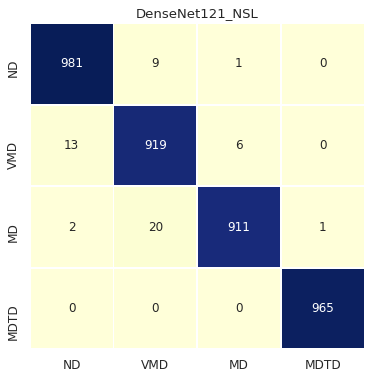

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, title="DenseNet121_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

TN: [2822 2861 2887 2862]
TP: [981 919 911 965]
FN: [10 19 23  0]
FP: [15 29  7  1]
Acc: [0.99346917 0.98746082 0.99216301 0.99973877]
ER(Error rate): [0.00653083 0.01253918 0.00783699 0.00026123]
Recall(TP rate): [0.98990918 0.97974414 0.97537473 1.        ]
Specialty(TN rate): [0.99471272 0.9899654  0.9975812  0.99965072]
Fall Out(FP rate): [0.00528728 0.0100346  0.0024188  0.00034928]
Miss Rate(FN rate): [0.01009082 0.02025586 0.02462527 0.        ]


#8.Xception & Xception-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

##5.1 Xception Base Model Training
### val_acc: 0.901, val_auc: 0.987, val_f1_score: 0.897

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.early_stop_base_line=0.90
params.train_epoch=50

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_restore_path)
'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "Xception_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2359424   
__________________________________________________

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "Xception_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
__________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     69/Unknown - 19s 277ms/step - loss: 0.9846 - accuracy: 0.5874 - auc: 0.8402 - f1_score: 0.5660

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.64368, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90
69/69 [==============================] - 29s 417ms/step - loss: 0.9846 - accuracy: 0.5874 - auc: 0.8402 - f1_score: 0.5660 - val_loss: 0.8324 - val_accuracy: 0.6437 - val_auc: 0.8853 - val_f1_score: 0.6391
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.6768 - auc: 0.9057 - f1_score: 0.6621
Epoch 00002: val_accuracy improved from 0.64368 to 0.69279, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90
69/69 [==============================] - 24s 342ms/step - loss: 0.7263 - accuracy: 0.6768 - auc: 0.9057 - f1_score: 0.6621 - val_loss: 0.6742 - val_accuracy: 0.6928 - val_auc: 0.9195 - val_f1_score: 0.6863
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.7086 - auc: 0.9240 - f1_score: 0.6999
Epoch 00

In [ ]:
"""evaluate base_model"""
base_model.evaluate(test_image_dataset)

30/30 [==============================] - 2s 61ms/step - loss: 0.2796 - accuracy: 0.9013 - auc: 0.9874 - f1_score: 0.8980


[0.27955442667007446,
 0.9012539386749268,
 0.9873639345169067,
 0.8979917764663696]

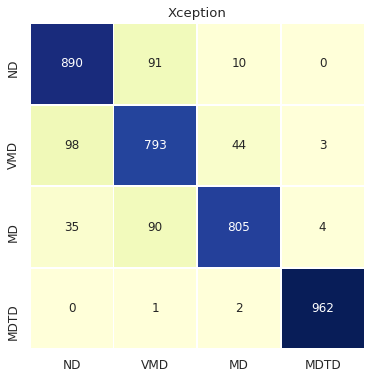

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]
ADModelBuilder.plot_confusion_mat(model=base_model, data=data, data_label=data_label, title="Xception", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=base_model, data=data, data_label=data_label)

TN: [2704 2708 2838 2856]
TP: [890 793 805 962]
FN: [101 145 129   3]
FP: [133 182  56   7]
Acc: [0.93887147 0.9145768  0.95167189 0.99738767]
ER(Error rate): [0.06112853 0.0854232  0.04832811 0.00261233]
Recall(TP rate): [0.89808274 0.84541578 0.86188437 0.99689119]
Specialty(TN rate): [0.95311949 0.93702422 0.98064962 0.99755501]
Fall Out(FP rate): [0.04688051 0.06297578 0.01935038 0.00244499]
Miss Rate(FN rate): [0.10191726 0.15458422 0.13811563 0.00310881]


##5.2 Xception_NSL Model Training
### val_acc: 0.954,val_auc: 0.990,val_f1_score:0.954

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'
'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00005
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95'
params.early_stop_base_line=0.95
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      2/Unknown - 1s 301ms/step - loss: 3.0072 - accuracy: 0.2500 - auc: 0.5468 - f1_score: 0.2443 - scaled_graph_loss: 0.0239WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2346s vs `on_train_batch_end` time: 0.3666s). Check your callbacks.
    137/Unknown - 82s 597ms/step - loss: 0.8293 - accuracy: 0.6618 - auc: 0.8905 - f1_score: 0.6381 - scaled_graph_loss: 0.0105
Epoch 00001: val_accuracy improved from -inf to 0.74974, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95
137/137 [==============================] - 88s 645ms/step - loss: 0.8293 - accuracy: 0.6618 - auc: 0.8905 - f1_score: 0.6381 - scaled_graph_loss: 0.0105 - val_loss: 0.5496 - val_accuracy: 0.7497 - val_auc: 0.9468 - val_f1_score: 0.6678
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8036 - auc: 0.9631 - f1_score: 0.7962 - scaled_graph_loss: 0.0080
Epoch 00002: val_

##5.3 Xception_NSL Model top 10 and bottom 5 layers tunning
### val_acc: 0.972, val_auc: 0.996, val_f1_score: 0.971

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00001
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_new_98'
params.early_stop_base_line=0.98
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

In [ ]:
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      2/Unknown - 1s 297ms/step - loss: 0.0806 - accuracy: 0.9766 - auc: 0.9992 - f1_score: 0.9725 - scaled_graph_loss: 0.0031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2242s vs `on_train_batch_end` time: 0.3688s). Check your callbacks.
    137/Unknown - 80s 587ms/step - loss: 0.0793 - accuracy: 0.9744 - auc: 0.9987 - f1_score: 0.9745 - scaled_graph_loss: 0.0028
Epoch 00001: val_accuracy improved from -inf to 0.95690, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_new_98
137/137 [==============================] - 87s 635ms/step - loss: 0.0793 - accuracy: 0.9744 - auc: 0.9987 - f1_score: 0.9745 - scaled_graph_loss: 0.0028 - val_loss: 0.1284 - val_accuracy: 0.9569 - val_auc: 0.9962 - val_f1_score: 0.9694
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9817 - auc: 0.9991 - f1_score: 0.9816 - scaled_graph_loss: 0.0022
Epoch 00002: 

In [ ]:
'''evaluate the model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 2s 34ms/step - loss: 0.0692 - accuracy: 0.9825 - auc: 0.9970 - f1_score: 0.9824


[0.06918579339981079,
 0.9824973940849304,
 0.9970408082008362,
 0.9823644757270813]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

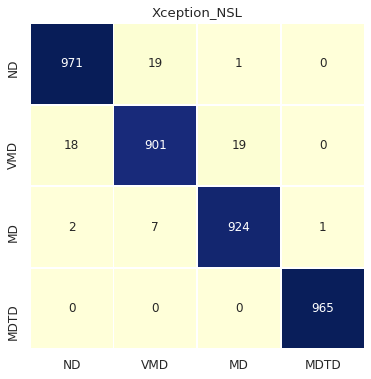

In [ ]:
ADModelBuilder.plot_confusion_mat(model=graph_reg_model, data=data, data_label=data_label, title="Xception_NSL", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

TN: [2817 2864 2874 2862]
TP: [971 901 924 965]
FN: [20 37 10  0]
FP: [20 26 20  1]
Acc: [0.98955068 0.98354232 0.99216301 0.99973877]
ER(Error rate): [0.01044932 0.01645768 0.00783699 0.00026123]
Recall(TP rate): [0.97981837 0.96055437 0.98929336 1.        ]
Specialty(TN rate): [0.9929503  0.99100346 0.99308915 0.99965072]
Fall Out(FP rate): [0.0070497  0.00899654 0.00691085 0.00034928]
Miss Rate(FN rate): [0.02018163 0.03944563 0.01070664 0.        ]
